In [1]:
import numpy as np
import pandas as pd
from toolz import curry
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import cvxpy as cp

from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
style.use("ggplot")

In [2]:
data = (pd.read_csv("data/smoking.csv")[["state", "year", "cigsale", "california", "after_treatment"]]
        .rename(columns={"california": "treated"})
        .replace({"state_3": "california"}))

data_piv = data.pivot("year", "state", "cigsale")
data_piv = data_piv.rename(columns={c: f"state_{c}" for c in data_piv.columns}).rename(columns={"state_3": "california"})

data.head()

,state,year,cigsale,treated,after_treatment
0,1,1970,89.800003,False,False
1,1,1971,95.400002,False,False
2,1,1972,101.099998,False,False
3,1,1973,102.900002,False,False
4,1,1974,108.199997,False,False


Text(0, 0.5, 'Cigarette Sales')

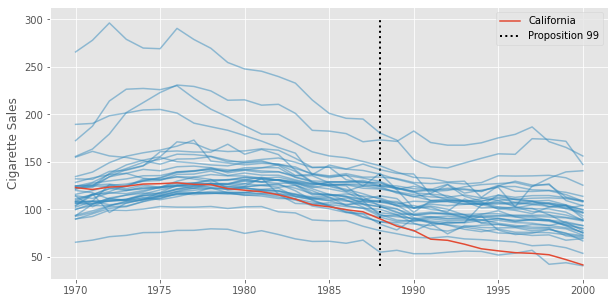

In [3]:
plt.figure(figsize=(10,5))
plt.plot(data_piv.drop(columns=["california"]), color="C1", alpha=0.5)
plt.plot(data_piv["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")

In [4]:
def calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    n_treated_post = data.query(post_col).query(treat_col).shape[0]
    
    first_diff_std = (data
                      .query(f"~{post_col}")
                      .query(f"~{treat_col}")
                      .groupby(state_col)
                      [outcome_col]
                      .diff()
                      .std())
    
    return n_treated_post**(1/4) * first_diff_std

    
def fit_unit_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    zeta = calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col)
        
    x_pre_control = (data
                     .query(f"~{post_col}")
                     .query(f"~{treat_col}")
                     .pivot(year_col, state_col, outcome_col))
    
    y_pre_treat_mean = (data
                        .query(f"~{post_col}")
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    # add intercept
    T_pre = x_pre_control.shape[0]
    X = np.concatenate([np.ones((T_pre, 1)), x_pre_control.values], axis=1) 
    
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X@w - y_pre_treat_mean.values) + T_pre*zeta**2 * cp.sum_squares(w[1:]))
    constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    return pd.Series(w.value[1:], # remove intercept
                     name="unit_weights",
                     index=x_pre_control.columns)

In [5]:
unit_weights = fit_unit_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

unit_weights.round(3)

state
1    -0.000
2    -0.000
4     0.057
5     0.078
6     0.070
7     0.002
8     0.032
9     0.053
10    0.010
11    0.026
12    0.022
13   -0.000
14   -0.000
15    0.028
16    0.040
17   -0.000
18    0.008
19    0.045
20    0.048
21    0.124
22    0.105
23    0.041
24    0.033
25   -0.000
26    0.032
27   -0.000
28    0.016
29    0.001
30   -0.000
31    0.004
32   -0.000
33    0.010
34    0.042
35   -0.000
36   -0.000
37    0.034
38    0.037
39    0.001
Name: unit_weights, dtype: float64

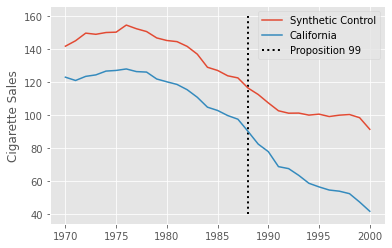

In [6]:
sc = data_piv.drop(columns="california").values @ unit_weights.values

plt.plot(data_piv.index, sc, label="Synthetic Control")
plt.plot(data_piv["california"], label="California")

plt.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales");

In [7]:
def fit_time_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
        
        control = data.query(f"~{treat_col}")
        
        X_pre = (control
                 .query(f"~{post_col}")
                 .pivot(state_col, year_col, outcome_col))
        
        y_post_mean = (control
                       .query(f"{post_col}")
                       .groupby(state_col)
                       [outcome_col]
                       .mean()
                       .values)
        
        X = np.concatenate([np.ones((X_pre.shape[0], 1)), X_pre.values], axis=1) # add intercept

        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X@w - y_post_mean))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        return pd.Series(w.value[1:], # remove intercept
                     name="time_weights",
                     index=X_pre.columns)

In [8]:
time_weights = fit_time_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

time_weights.round(3)

year
1970   -0.000
1971   -0.000
1972   -0.000
1973   -0.000
1974   -0.000
1975   -0.000
1976   -0.000
1977   -0.000
1978   -0.000
1979   -0.000
1980   -0.000
1981   -0.000
1982   -0.000
1983   -0.000
1984   -0.000
1985   -0.000
1986    0.366
1987    0.206
1988    0.427
Name: time_weights, dtype: float64

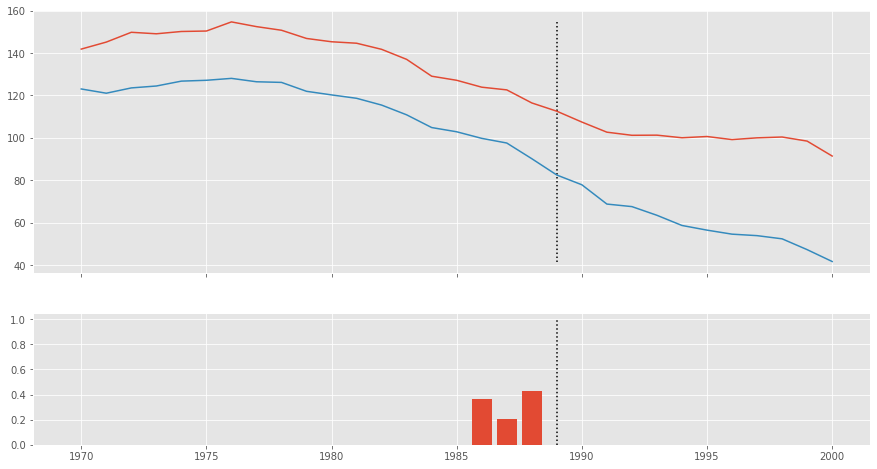

In [9]:
sc = data_piv.drop(columns="california").values @ unit_weights.values

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

ax1.plot(data_piv.index, sc)
ax1.plot(data_piv.index, data_piv["california"])
ax1.vlines(1989, data_piv["california"].min(), sc.max(), color="black", ls="dotted")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(1989, 0, 1, color="black", ls="dotted")

In [10]:
pre_sc = (sc[0:len(time_weights)] * time_weights).sum()
post_sc = sc[len(time_weights):].mean()

pre_treat = (data_piv["california"].iloc[0:len(time_weights)] * time_weights).sum()
post_treat = data_piv["california"].iloc[len(time_weights):].mean()

In [11]:
sc_did_y0 = pre_treat + (post_sc - pre_sc)
sc_did_att = (post_sc - pre_sc) - (post_treat - pre_treat)
sc_did_att

15.605397899247741

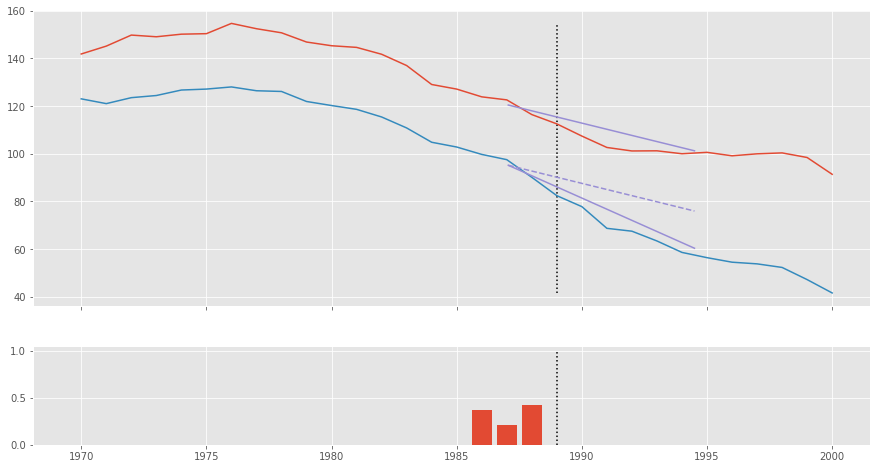

In [12]:
sc = data_piv.drop(columns="california").values @ unit_weights.values
avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = 1989 + (2000 - 1989) / 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(data_piv.index, sc)
ax1.plot(data_piv.index, data_piv["california"])
ax1.vlines(1989, data_piv["california"].min(), sc.max(), color="black", ls="dotted")

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2", ls="dashed")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(1989, 0, 1, color="black", ls="dotted")

In [13]:
def join_weights(data, unit_w, time_w, year_col, state_col, treat_col, post_col):

    return (
        data
        .set_index([year_col, state_col])
        .join(time_w)
        .join(unit_w)
        .reset_index()
        .fillna({time_w.name: data[post_col].mean(),
                 unit_w.name: data[treat_col].mean()})
        .assign(**{"weights": lambda d: d[time_w.name]*d[unit_w.name]})
        .astype({treat_col:int, post_col:int}))

In [14]:
did_data = join_weights(data, unit_weights, time_weights,
                        year_col="year",
                        state_col="state",
                        treat_col="treated",
                        post_col="after_treatment")

did_data.head()

,year,state,cigsale,treated,after_treatment,time_weights,unit_weights,weights
0,1970,1,89.800003,0,0,-4.600041e-14,-1.360835e-16,6.259896e-30
1,1971,1,95.400002,0,0,-4.582326e-14,-1.360835e-16,6.235789e-30
2,1972,1,101.099998,0,0,-5.274204e-14,-1.360835e-16,7.177320e-30
3,1973,1,102.900002,0,0,-5.766365e-14,-1.360835e-16,7.847071e-30
4,1974,1,108.199997,0,0,-5.617991e-14,-1.360835e-16,7.645158e-30


In [15]:
smf.wls("cigsale ~ after_treatment*treated",
        data=did_data,
        weights=did_data["weights"]+1e-10).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,120.4060,1.965,61.278,0.000,116.551,124.261
after_treatment,-19.1905,2.166,-8.859,0.000,-23.440,-14.941
treated,-25.2601,12.427,-2.033,0.042,-49.641,-0.879
after_treatment:treated,-15.6054,13.700,-1.139,0.255,-42.483,11.272


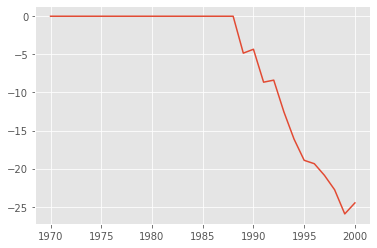

In [16]:
model = smf.wls("cigsale ~ treated:after_treatment:C(year) + C(state) + C(year)",
        data=did_data,
        weights=did_data["weights"] + 1e-10,
       ).fit()

effect = pd.Series(model.params[model.params.index.str.contains("treated")].values,
                   index=sorted(did_data["year"].unique()))
effect.plot();

In [17]:
def synthetic_diff_in_diff(data, outcome_col, year_col, state_col, treat_col, post_col, formula=None):
    
    unit_weights = fit_unit_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)
    
    time_weights = fit_time_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)

    did_data = join_weights(data, unit_weights, time_weights,
                            year_col=year_col,
                            state_col=state_col,
                            treat_col=treat_col,
                            post_col=post_col)

    formula = f"{outcome_col} ~ {post_col}*{treat_col}" if formula is None else formula
    did_model = smf.wls(formula, data=did_data, weights=did_data["weights"]+1e-10).fit()
    
    return did_model
    

In [18]:
m = synthetic_diff_in_diff(data, 
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

In [19]:
m.params

Intercept                  120.405986
after_treatment            -19.190472
treated                    -25.260115
after_treatment:treated    -15.605399
dtype: float64

In [20]:
m = synthetic_diff_in_diff(data, 
                           outcome_col="cigsale",
                           year_col="year",
                           state_col="state",
                           treat_col="treated",
                           post_col="after_treatment",
                           formula="cigsale ~ treated:after_treatment:C(year) + C(state) + C(year)")

In [21]:
m.params

Intercept                                111.218854
C(state)[T.2]                              7.100002
C(state)[T.3]                            -14.316313
C(state)[T.4]                             -5.966381
C(state)[T.5]                             -8.232798
                                            ...    
treated:after_treatment:C(year)[1996]    -19.355845
treated:after_treatment:C(year)[1997]    -20.887479
treated:after_treatment:C(year)[1998]    -22.775348
treated:after_treatment:C(year)[1999]    -25.945558
treated:after_treatment:C(year)[2000]    -24.499197
Length: 100, dtype: float64